# OCR
 

## Imports

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import string


import letter_detection_utils as ld_util
import preprocessing as pp
import ressources as rss
import modele as mdl
import rendering as rd
import metric_orthograph as mo
import matplotlib.pyplot as plt

# initialisation des variables globales
rss.init()



In [2]:
# Pour recharger les libs pendant les devs
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)
reload(mdl)
reload(rd)
reload(mo)

<module 'metric_orthograph' from '/Users/jpec/Prog/OCRpyMAN/notebooks/metric_orthograph.py'>

## Text detection

In [84]:
from doctr.models import ocr_predictor
from doctr.io import DocumentFile

form_img_path = '../data/formsA-D/a01-000u.png'
form_img = plt.imread(form_img_path)
img_size = (form_img.shape[0], form_img.shape[1])

def load_text_detection_model():
    DET_CKPT = "text_detection/straight_model/weights"
    straight_model = ocr_predictor(det_arch='db_resnet50', pretrained=True)
    straight_model.det_predictor.model.load_weights(DET_CKPT)
    return straight_model

def get_image_bounding_boxes(img_path):
    straight_model = load_text_detection_model()
    doc = DocumentFile.from_images(img_path)
    return straight_model.det_predictor(doc)[0]

def format_bounding_boxes(bounding_boxes, size = (1, 1)):
    return [ [bbox[0] * size[1], bbox[1] * size[0], bbox[2] * size[1], bbox[3] * size[0]] for bbox in bounding_boxes ]

def format_bounding_boxes_xyhw(bounding_boxes, size = (1, 1)):
    return [ [bbox[0] * size[1], bbox[1] * size[0], (bbox[3] - bbox[1]) * size[0], (bbox[2] - bbox[0]) * size[1]] for bbox in bounding_boxes ]


doctr_bboxes = get_image_bounding_boxes(form_img_path)
bounding_boxes = format_bounding_boxes(doctr_bboxes, img_size)
bounding_boxes_xyhw = format_bounding_boxes_xyhw(doctr_bboxes, img_size)

2023-02-14 22:38:17.412 INFO    root: Using downloaded & verified file: /Users/jpec/.cache/doctr/models/db_resnet50-adcafc63.zip
2023-02-14 22:38:18.733 INFO    root: Using downloaded & verified file: /Users/jpec/.cache/doctr/models/crnn_vgg16_bn-76b7f2c6.zip


In [22]:
# df_detection = pd.DataFrame(bounding_boxes)
# df_detection = df_detection.drop(df_detection.columns[4], axis=1)
# df_detection.rename(columns = {0:'y',1:'x',2:'h',3:'w'}, inplace = True)
# df_detection.head()

In [85]:
def plot_bounding_boxes(bounding_boxes):
    for bbox in bounding_boxes:
        xmin = bbox[0]
        ymin = bbox[1] 
        xmax = bbox[2] 
        ymax = bbox[3] 
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color='red')

def plot_bounding_boxes_xyhw(bounding_boxes):
    for bbox in bounding_boxes:
        xmin = bbox[0] 
        ymin = bbox[1] 
        xmax = (bbox[3] + bbox[0])
        ymax = (bbox[2] + bbox[1])
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color='red')

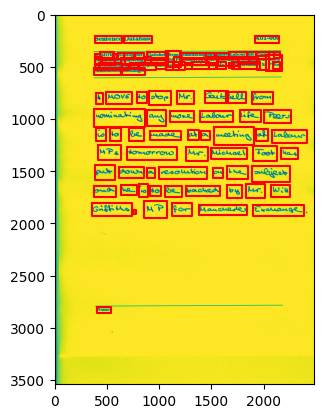

In [87]:
form_img = plt.imread(form_img_path)
size = form_img.shape[0], form_img.shape[1]
# plot_bounding_boxes_xyhw(bounding_boxes_xyhw)
plot_bounding_boxes(bounding_boxes)
plt.imshow(form_img)
plt.show()

### Testing with an image stream

In [88]:
straight_model = load_text_detection_model()

form_img_path = '../data/formsA-D/a01-000u.png'
form_img = plt.imread(form_img_path)

doc = DocumentFile.from_images(bytearray(form_img))
doctr_coords = straight_model.det_predictor(doc)[0]
doctr_coords

2023-02-14 22:41:47.523 INFO    root: Using downloaded & verified file: /Users/jpec/.cache/doctr/models/db_resnet50-adcafc63.zip
2023-02-14 22:41:48.950 INFO    root: Using downloaded & verified file: /Users/jpec/.cache/doctr/models/crnn_vgg16_bn-76b7f2c6.zip


TypeError: unsupported object type for argument 'file'

## Text recognition

### POC

In [38]:
df = pd.read_pickle('../pickle/df.pickle')

In [49]:
def load_image(filepath, resize=None):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_png(im, channels=0)
    if resize:
        return tf.image.resize(im, resize)
    return im

[]

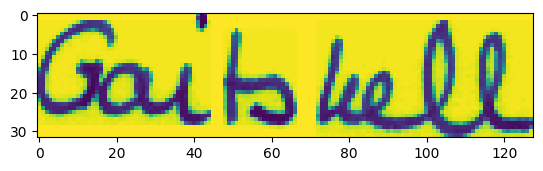

In [68]:
word_img_path = df.iloc[5].word_img_path
word_img = load_image(word_img_path, (32, 128));
plt.imshow(word_img);
plt.plot()

In [69]:
np.array([word_img]).shape

(1, 32, 128, 1)

In [70]:
reco_model = tf.keras.models.load_model("../pickle/tj_ctc_augmented_20epochs_LR-plateau", custom_objects={"CTCLoss": mdl.CTCLoss})

In [71]:
# reco_predictions = reco_model.predict(np.array([word_img]))
reco_predictions = reco_model.predict(
    np.array(word_img).reshape(1,word_img.shape[0],word_img.shape[1],1)
)

1/1 [==============================] - 0s 46ms/step


/Users/jpec/miniconda3/envs/work/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [66]:
mots = ld_util.greedy_decoder(reco_predictions, rss.charList)
print(mots)

['']


### Using form extracted img

2023-02-14 22:56:00.389 INFO    root: Using downloaded & verified file: /Users/jpec/.cache/doctr/models/db_resnet50-adcafc63.zip
2023-02-14 22:56:02.193 INFO    root: Using downloaded & verified file: /Users/jpec/.cache/doctr/models/crnn_vgg16_bn-76b7f2c6.zip


(3542, 2479)


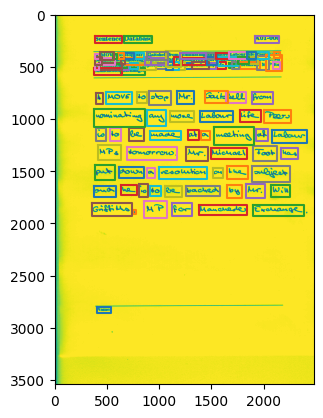

[]

In [95]:
def load_text_detection_model():
    DET_CKPT = "text_detection/straight_model/weights"
    straight_model = ocr_predictor(det_arch='db_resnet50', pretrained=True)
    straight_model.det_predictor.model.load_weights(DET_CKPT)
    return straight_model

def make_ocr(img_path, with_display = False):
    text_detection_model = load_text_detection_model()
    doc = DocumentFile.from_images(img_path)

    img_arr = load_image(img_path)
    img_size = (img_arr.shape[0], img_arr.shape[1])
    doctr_bboxes = text_detection_model.det_predictor(doc)[0]
    bounding_boxes = format_bounding_boxes(doctr_bboxes, img_size)
    bounding_boxes_xyhw = format_bounding_boxes_xyhw(doctr_bboxes, img_size)

    box_texts = []

    # recognition_model = tf.keras.models.load_model("../pickle/tj_ctc_augmented_20epochs_LR-plateau", custom_objects={"CTCLoss": mdl.CTCLoss})
    # for bounding_box_xyhw in bounding_boxes_xyhw:
    #     # https://www.tensorflow.org/api_docs/python/tf/image/crop_and_resize
    #     word_img = tf.image.crop_and_resize(img_arr, bounding_box_xyhw)
    #     word_img = tf.image.crop_and_resize(image, boxes, box_indices, (32, 128))
    #     box_text_probs = recognition_model.predict(word_img) 
    #     box_text = ld_util.greedy_decoder(box_text_probs, rss.charList)
    #     box_texts.append(box_text)

    if with_display: 
        plt.imshow(img_arr)
        for bounding_box in bounding_boxes_xyhw:
            x = bounding_box[0]
            y = bounding_box[1]
            h = bounding_box[2]
            w = bounding_box[3]
            plt.plot([x, x+w, x+w, x, x], [y, y, y+h, y+h, y])
        plt.show()

    return box_texts

make_ocr(form_img_path, True)

# Thibault

In [36]:

# Création du dataset pour la reconnaissance du texte : TODO prend en parametre le retour du modele de détection de texte

# dataset = ld_util.get_dataset_for_prediction(file_path=form_img_path, coords=df_detection)


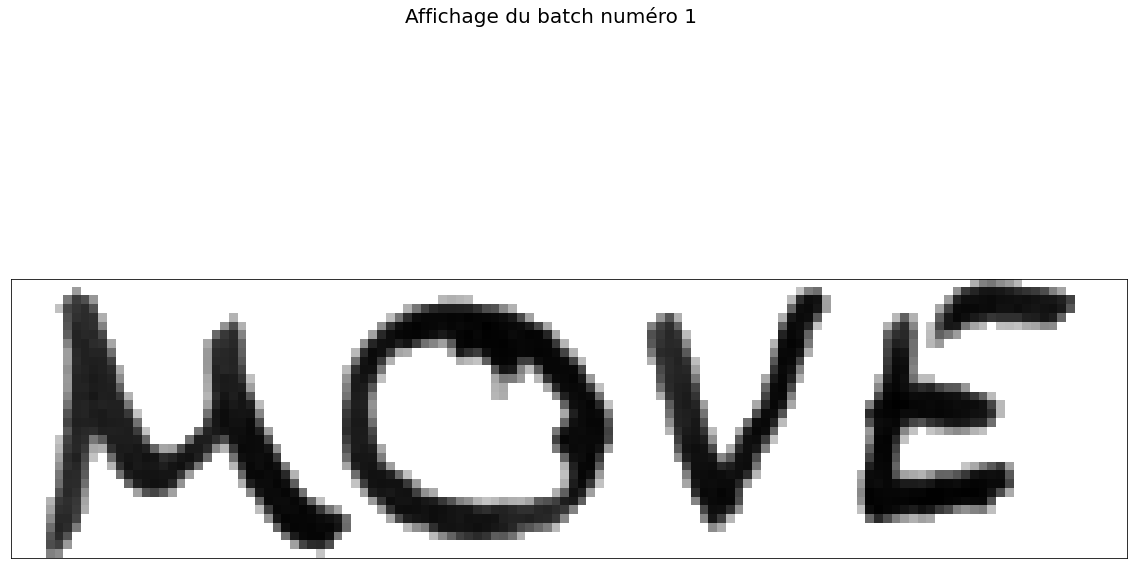

In [11]:
#TEST affichage d'un mot depuis formulaire avec dataset

batch_id=0
iterator = iter(dataset)

x = iterator.get_next()
batch_id +=1
# rd.show_iterator_batch(x,'y',batch_id, 4)

lin = 11
col = 6
fig = plt.figure(figsize=(20,12))
    
img = x[1]

plt.imshow(img,cmap='gray')
# plt.title(str(i)+' : '+str(liste_label[i]))
plt.xticks([], [])
plt.yticks([], [])
plt.suptitle('Affichage du batch numéro '+str(batch_id), size = 20);

In [12]:
# Utilisation du modele avec dataset formulaire
preds = model.predict(dataset)
mots = ld_util.greedy_decoder(preds, rss.charList)

print(mots)

4/4 [==============================] - 2s 185ms/step
['A', 'MOVE', 'to', 'stop', 'Mr.', 'Gaitskell', 'from', 'hominating', 'any', 'more', 'Labour', 'life', 'Peers', 'is', 'to', 'be', 'made', 'at', 'a', 'meeting']
